In [1]:
from PIL import Image, ImageDraw, ImageEnhance
from tensorflow.keras.utils import Sequence
import os
import random
import cv2
import numpy as np
from skimage.segmentation import slic
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

class DataGenerator(Sequence):
    def __init__(self, folder_path, image_size, batch_size=4, augment=True):
        """
        target classes can be a list from Good Crypts / Good Villi / Interpretable Region / Epithelium / Muscularis Mucosa
        mode should be one of 'seg', 'loc' or 'full'
        """
        print("Initialising data generator")
        # Making the image ids list
        self.folder_path = folder_path
        self.image_size = image_size
        image_paths = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
        self.image_ids = [f.replace('.jpg', '') for f in image_paths]
        self.batch_size = batch_size
        self.augment = augment
        print("Image count in {} path: {}".format(self.folder_path,len(self.image_ids)))
        self.on_epoch_end()

    def on_epoch_end(self):
        random.shuffle(self.image_ids)

    def __len__(self):
        """ Returns the number of batches per epoch """
        gen_len = len(self.image_ids) // self.batch_size
        if len(self.image_ids) % self.batch_size != 0:
            gen_len += 1
        return gen_len

    def load_image(self, index):
        """
        Load an image at the index.
        Returns PIL image
        """
        image_path = os.path.join(self.folder_path, self.image_ids[index] + '.jpg')
        img = Image.open(image_path).convert('RGB')
        w, h = img.size
        if w != self.image_size[0] and h != self.image_size[1]:
            img = img.resize((self.image_size[0], self.image_size[1]))
        return img

    def augment_instance(self, img, flip_hor=None, flip_ver=None, rotate_90=None, brightness_factor=None, contrast_factor=None):
        """
        Args:
            PIL img
        Takes in an image and creates M+1 transformations of it and returns a query image along with its positive key images.
        """
        if flip_hor is None:
            flip_hor = np.random.randint(2)
            # flip_hor = 0
        if flip_ver is None:
            flip_ver = np.random.randint(2)
            # flip_ver = 0
        if rotate_90 is None:
            rotate_90 = np.random.randint(4)
            # rotate_90 = 1
        if brightness_factor is None:
            brightness_factor = 0.2 * random.random() + 0.9
        if contrast_factor is None:
            contrast_factor = 0.2 * random.random() + 0.9

        w, h = img.size

        # Flip left-right
        if flip_hor == 1:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        
        # Flip top-bottom
        if flip_ver == 1:
            img = img.transpose(Image.FLIP_TOP_BOTTOM)
        
        # rotate 90 degrees anticlock
        if rotate_90 >= 1:
            img = img.rotate(90, expand = True)
            # Now image is in portrait shape, We need landscape window from it
            w_new, h_new = img.size
            w_crop = h
            h_crop = int(h * (w_crop / w))
            left = 0
            right = h
            upper = int(random.random() * (h_new - h))
            lower = upper + h_crop
            rotation_crop = (left, upper, right, lower)
            img = img.crop(rotation_crop)
            img = img.resize((w, h))

            # random brightness and contrast   
            brighten = ImageEnhance.Brightness(img)
            img = brighten.enhance(brightness_factor)
            contrast = ImageEnhance.Contrast(img)
            img = contrast.enhance(contrast_factor)
            
        return img

    def preprocess_instance(self, superPixel, image):
        """
        Args:
            PIL image
        """
        w, h = superPixel.size
        superPixel = np.array(superPixel)
        # Convert (H, W, C) to (W. H, C)
        superPixel = np.transpose(superPixel, (1, 0, 2))
        # img = np.clip(img - np.median(img)+127, 0, 255)
        superPixel = superPixel.astype(np.float32)
        # img = (img - np.min(img)) / (np.max(img) - np.min(img))
        superPixel = superPixel/255.0
        
        w, h = image.size
        image = np.array(image)
        # Convert (H, W, C) to (W. H, C)
        image = np.transpose(image, (1, 0, 2))
        # img = np.clip(img - np.median(img)+127, 0, 255)
        image = image.astype(np.float32)
        # img = (img - np.min(img)) / (np.max(img) - np.min(img))
        image = image/255.0
        return image, superPixel

    def elastic(self, image, alpha, sigma, random_state=None):
        """Elastic deformation of images as described in [Simard2003]_.
            .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
               Convolutional Neural Networks applied to Visual Document Analysis", in
               Proc. of the International Conference on Document Analysis and
               Recognition, 2003.
            """
        if random_state is None:
            random_state = np.random.RandomState(None)


        #print(random_state)
        shape = image.shape
        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dz = np.zeros_like(dx)


        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))


        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
        distored_image = map_coordinates(image, indices, order=1, mode='nearest')  #wrap,reflect, nearest

        return distored_image.reshape(image.shape)

    def get_instance(self, index):
        """
        index is the index of the sample in the main array of indices
        returns the PIL image, a dict of label: masks with bboxes of IRs in format (x, y, w, h) where x, y are top left coords
        """
        # start = time.time()
        # Load the source image and its annotations
        img = self.load_image(index)
        w, h  = img.size

        # Perform random augmentations
        if self.augment:
            img = self.augment_instance(img)

        superPixel = np.array(img)
        real_image = np.array(img)
        enhancer = ImageEnhance.Contrast(img)
        pink_mass = enhancer.enhance(4.0)
        pink_mass = np.array(pink_mass)
        pink_mass = 255 - ((pink_mass[:, :, 0] > 150) * (pink_mass[:, :, 1] > 150) * (pink_mass[:, :, 2] > 150)) * 255
        pink_mass = pink_mass/255
        img = np.array(img)
        img[:,:,0] = img[:,:,0]*pink_mass
        img[:,:,1] = img[:,:,1]*pink_mass
        img[:,:,2] = img[:,:,2]*pink_mass
        element = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
        img = cv2.erode(img, element, iterations = 1)
        img = cv2.dilate(img, element, iterations = 1)
        img = cv2.erode(img, element)

        # apply SLIC and extract (approximately) the supplied number of segments
        segments = slic(real_image, n_segments = 500, sigma = 5)

        # Randomly uniformly sample superpixel clusters
        for i in range(500):
            k = int(np.random.uniform(np.min(segments),np.max(segments)))
            if np.sum(img[segments==k])>2000:
                real_image[segments==k] = 0

        real_image = self.elastic(real_image, 3500, 8, random_state=None)

        # Preprocess the image, masks and bboxes
        superPixel, real_image = self.preprocess_instance(Image.fromarray(superPixel), Image.fromarray(real_image))
        
        # print("Aug and preprocess time = {:.5f}s".format(time.time() - start))
        # start = time.time()

        return superPixel, real_image

    def getitem(self, index):
        """
        index is the index of batch here
        """
        # start = time.time()

        batch_indices = [i for i in range(index*self.batch_size, (index+1)*self.batch_size)]
        batch_indices = [i % len(self.image_ids) for i in batch_indices]
        superPixel_imgs = []
        real_imgs = []
        for ind in batch_indices:
            # istart = time.time()
            superpixel, image = self.get_instance(ind)
            # print("Instance time = {:.5f}s".format(time.time() - istart))
            superPixel_imgs.append(superpixel)
            real_imgs.append(image)
        superPixel_imgs = np.array(superPixel_imgs)   # (B, w, h, 3)
        real_imgs = np.array(real_imgs) # (B, M, w, h, 3)

        # print("Batch generation time = {:.5f}s".format(time.time() - start))
        return superPixel_imgs, real_imgs


    def __getitem__(self, index):
        return self.getitem(index)

In [2]:
image_size = (320, 256)
loader = DataGenerator("/home/ajey/Desktop/CDID/Train_test_val/corrected/unlabelled", batch_size=1, image_size=image_size)

Initialising data generator
Image count in /home/ajey/Desktop/CDID/Train_test_val/corrected/unlabelled path: 1150


<ipython-input-1-97105b59035b>:185: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(real_image, n_segments = 500, sigma = 5)


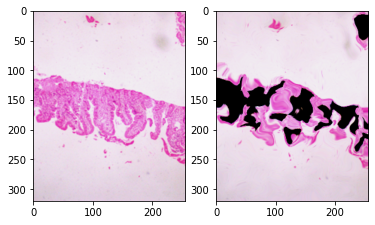

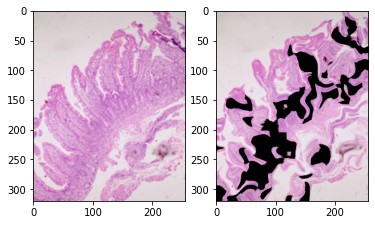

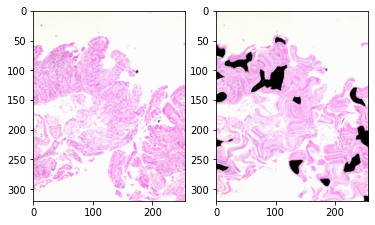

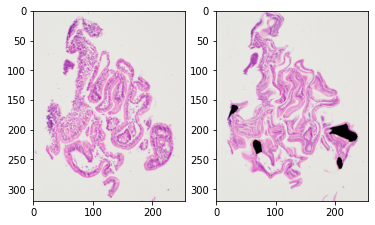

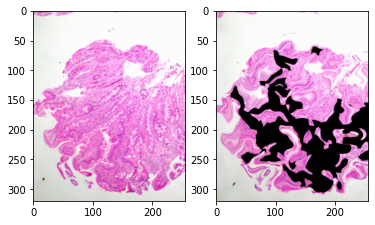

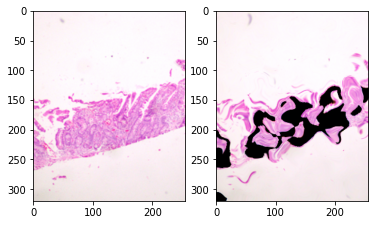

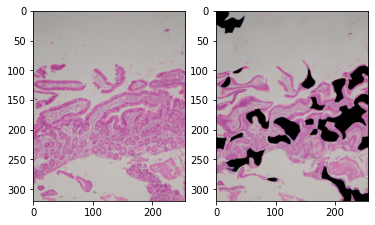

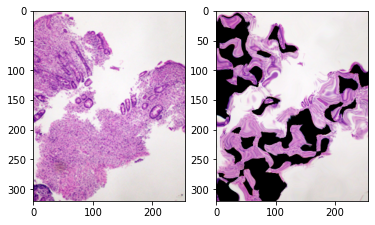

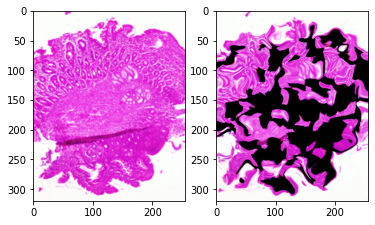

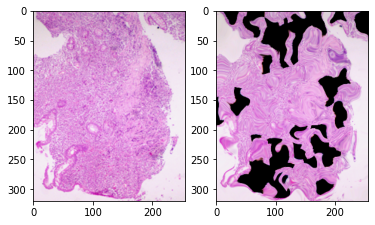

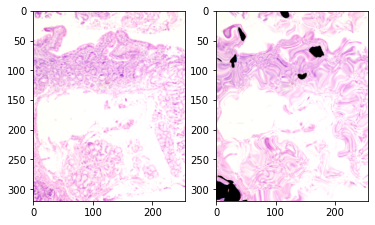

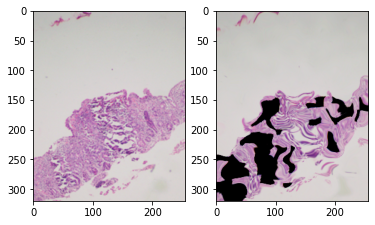

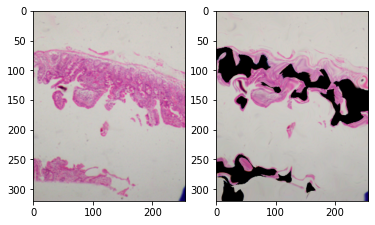

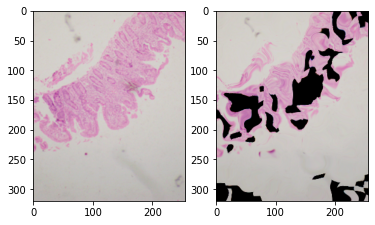

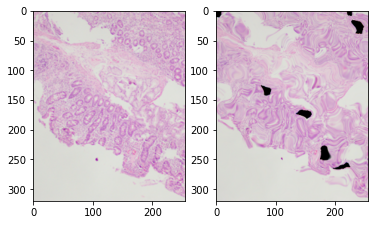

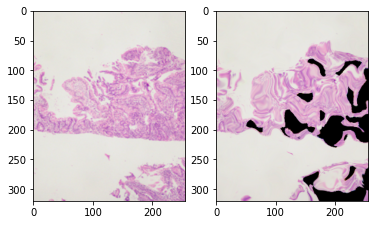

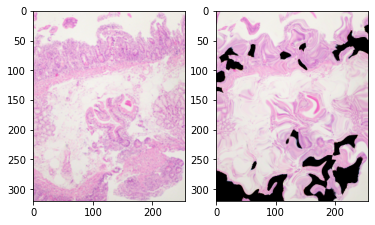

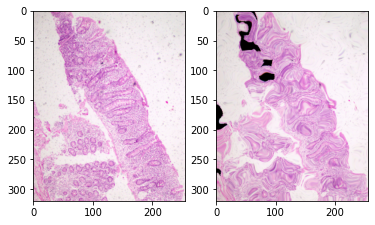

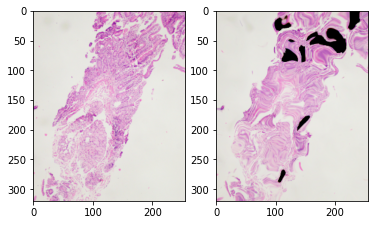

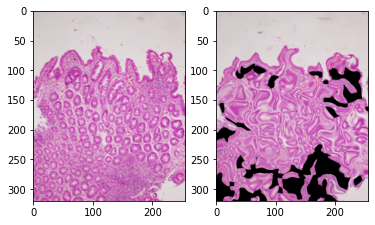

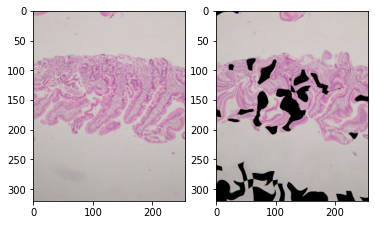

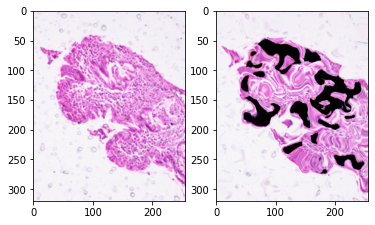

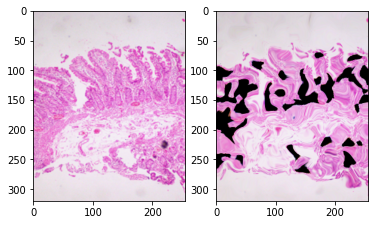

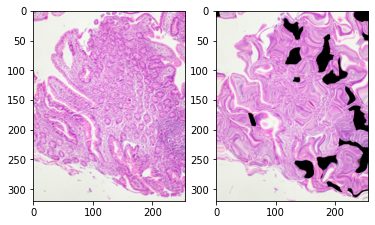

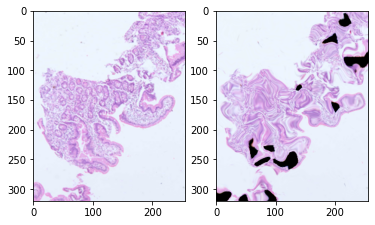

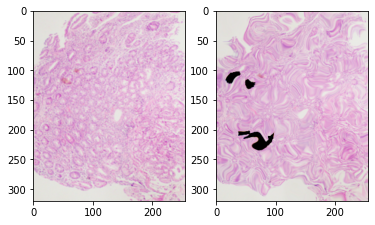

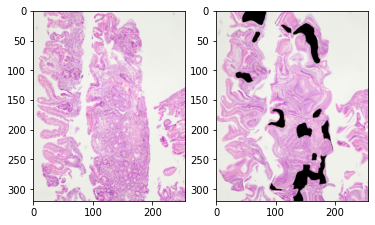

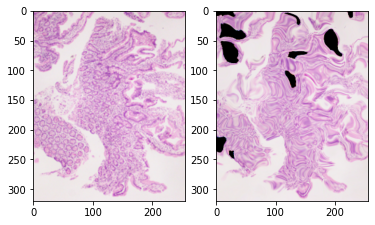

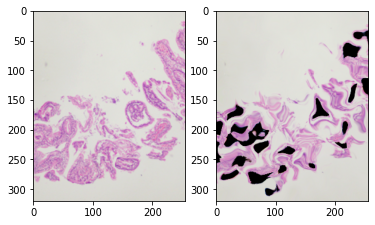

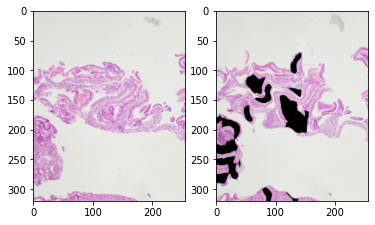

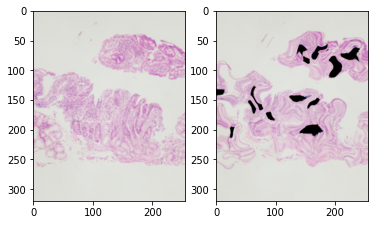

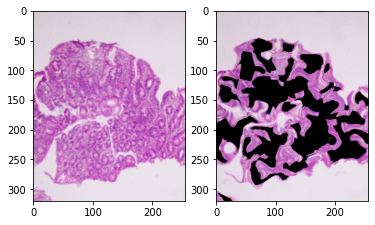

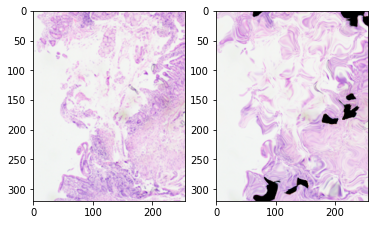

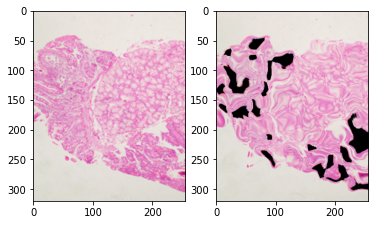

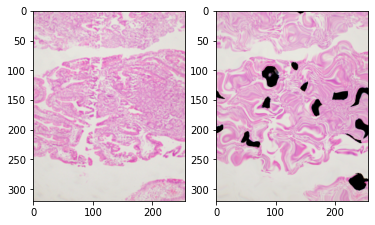

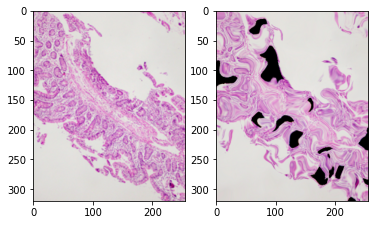

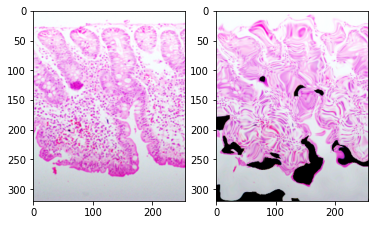

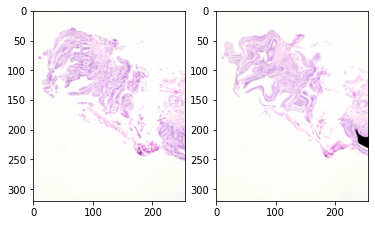

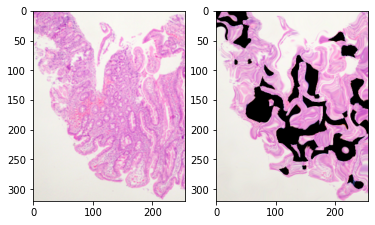

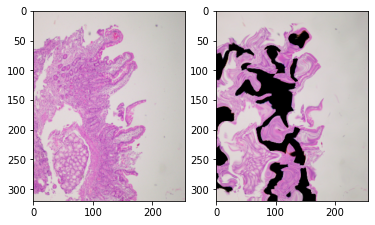

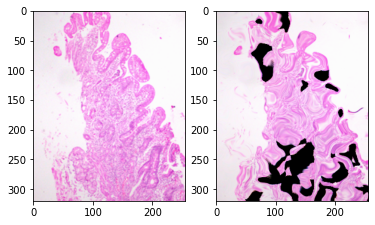

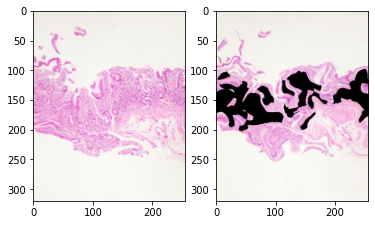

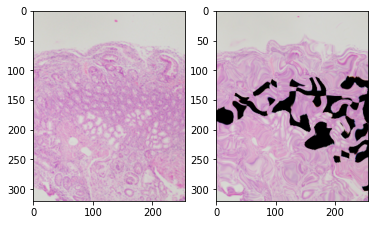

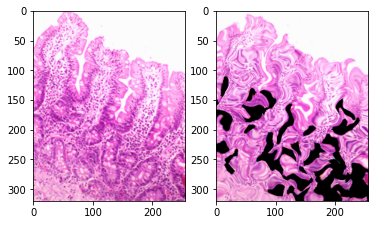

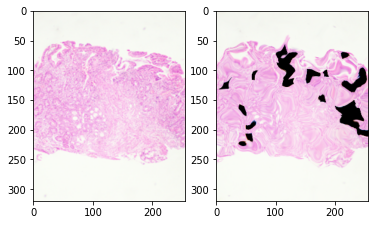

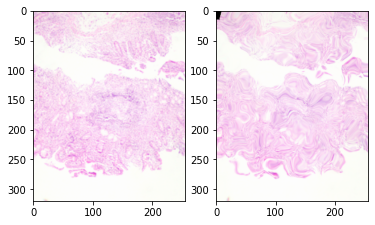

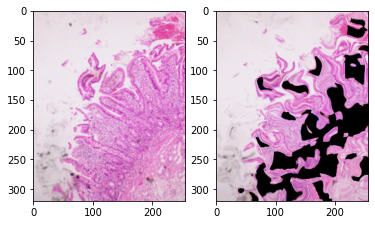

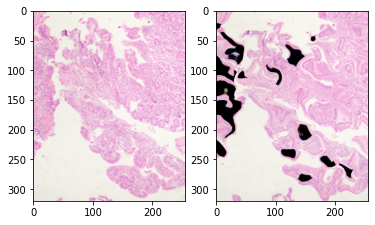

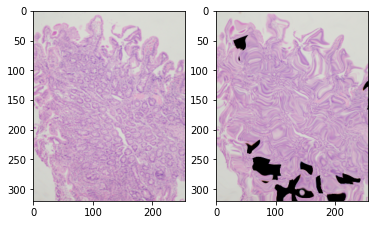

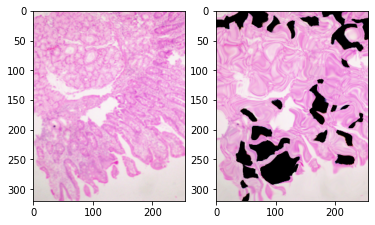

In [3]:
for i in range(50):
    SuperPixel, Real= loader.__getitem__(i)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(Real[0])
    ax2.imshow(SuperPixel[0])
    plt.show()

In [ ]:
from PIL import ImageChops
import numpy as np
import cv2

image = Image.open("/home/ajey/Desktop/CDID/Original_pictures/0890_3b_Image_13646.jpg")
enhancer = ImageEnhance.Contrast(image)
pink_mass = enhancer.enhance(4.0)
pink_mass = np.array(pink_mass)
pink_mass = 255 - ((pink_mass[:, :, 0] > 150) * (pink_mass[:, :, 1] > 150) * (pink_mass[:, :, 2] > 150)) * 255
pink_mass = pink_mass/255
image = np.array(image)
image[:,:,0] = image[:,:,0]*pink_mass
image[:,:,1] = image[:,:,1]*pink_mass
image[:,:,2] = image[:,:,2]*pink_mass
element = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
image = cv2.erode(image, element, iterations = 1)
image = cv2.dilate(image, element, iterations = 1)
image = cv2.erode(image, element)
plt.imshow(image)
plt.show()

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import argparse
from PIL import Image, ImageEnhance
import numpy as np
import cv2
# construct the argument parser and parse the arguments
# load the image and convert it to a floating point data type
real_image = cv2.imread("/home/ajey/Desktop/CDID/Original_pictures/0890_3b_Image_13646.jpg")
image = Image.open("/home/ajey/Desktop/CDID/Original_pictures/0890_3b_Image_13646.jpg")
enhancer = ImageEnhance.Contrast(image)
pink_mass = enhancer.enhance(4.0)
pink_mass = np.array(pink_mass)
pink_mass = 255 - ((pink_mass[:, :, 0] > 150) * (pink_mass[:, :, 1] > 150) * (pink_mass[:, :, 2] > 150)) * 255
pink_mass = pink_mass/255
image = np.array(image)
image[:,:,0] = image[:,:,0]*pink_mass
image[:,:,1] = image[:,:,1]*pink_mass
image[:,:,2] = image[:,:,2]*pink_mass
element = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
image = cv2.erode(image, element, iterations = 1)
image = cv2.dilate(image, element, iterations = 1)
image = cv2.erode(image, element)

# apply SLIC and extract (approximately) the supplied number of segments
segments = slic(real_image, n_segments = 500, sigma = 5)

# Randomly uniformly sample superpixel clusters
for i in range(150):
    k = int(np.random.uniform(np.min(segments),np.max(segments)))
    if np.sum(image[segments==k])>2000:
        real_image[segments==k] = 0

# show the output of SLIC
plt.imshow(real_image)
plt.show()